In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.image_unet as image_unet
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the dataloader

In [3]:
image_to_tensor = torchvision.transforms.ToTensor()
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda x: torch.round(image_to_tensor(x)))
)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:] 

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliSkipDiffuser(6, 8, input_shape)

t_limit = 50

model = image_unet.MNISTProbUNetTimeAdd(t_limit).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models/mnist"

import model.train_model as train_model  # Import this AFTER setting environment

### Show the forward-diffusion process

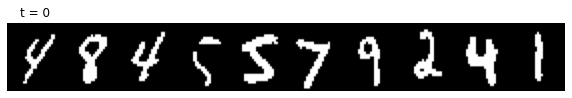

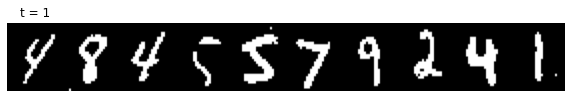

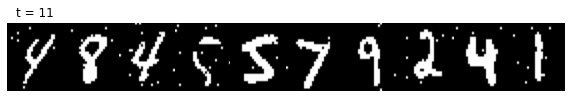

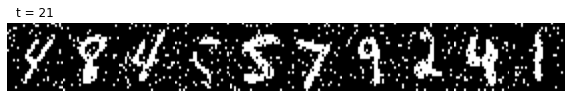

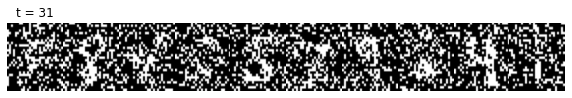

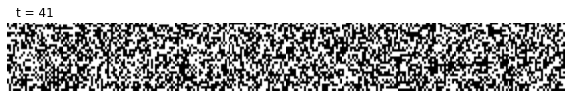

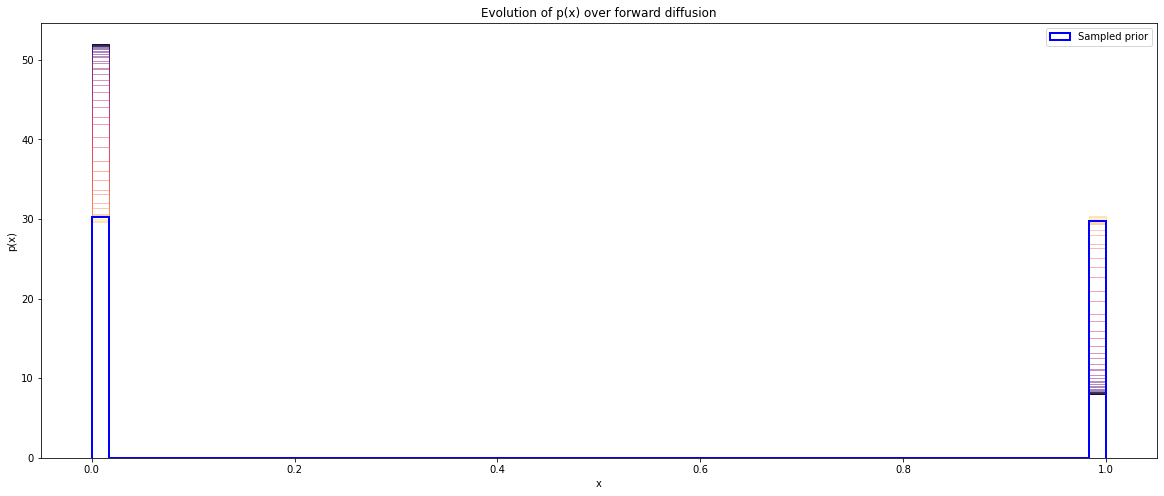

In [5]:
 # Show some images after running the diffuser forward for different times
time_steps = 5

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.arange(1, t_limit + 1, t_limit // time_steps):
    xt, _ = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %d" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.arange(1, t_limit, t_limit // time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = diffuser.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward diffusion")
plt.legend()
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

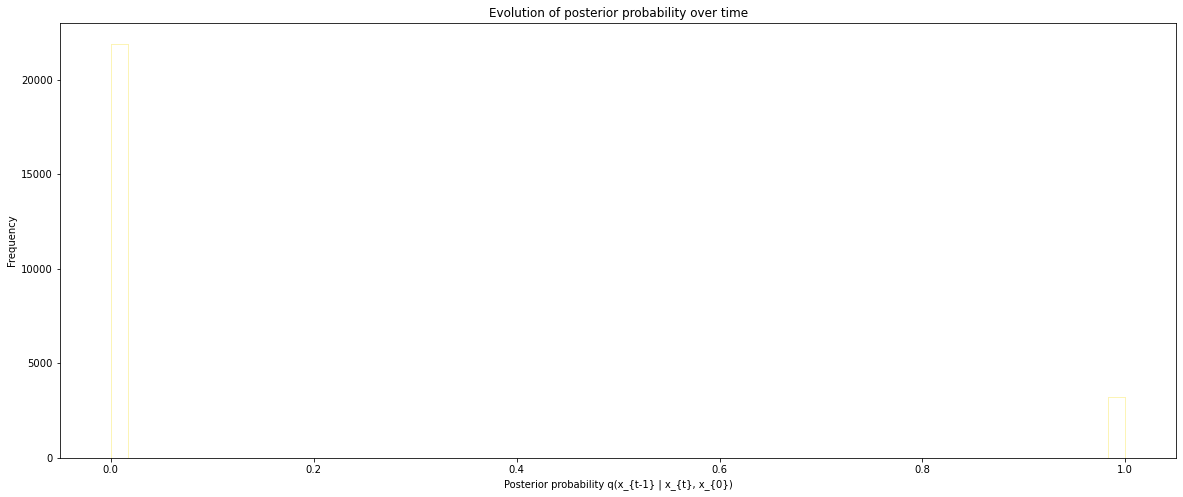

In [6]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
x0, _ = next(iter(data_loader))
posterior_probs = np.empty((len(t_vals), *x0.shape))
x0 = x0.to(DEVICE)
t_0 = torch.zeros(x0.shape[0], device=DEVICE)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.ones(x0.shape[0], device=DEVICE) * t
    xt, p = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 8))
posterior_probs_flattened = posterior_probs.reshape(posterior_probs.shape[0], -1)
times = np.tile(t_vals[:, None], (1, posterior_probs_flattened.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 60)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs_flattened[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)))
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [7]:
train_model.train_ex.run(
    "train_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "num_epochs": 10,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "4"
Loss: 0.0993: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 63.16it/s]


Epoch 1 average Loss: 0.1201


Loss: 0.0992: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 63.15it/s]


Epoch 2 average Loss: 0.1101


Loss: 0.1156: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 63.35it/s]


Epoch 3 average Loss: 0.1091


Loss: 0.1357: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 63.65it/s]


Epoch 4 average Loss: 0.1079


Loss: 0.0927: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 64.01it/s]


Epoch 5 average Loss: 0.1076


Loss: 0.0847: 100%|██████████████████████████████████████| 1875/1875 [00:29<00:00, 63.37it/s]


Epoch 6 average Loss: 0.1064


Loss: 0.1088:  47%|██████████████████▎                    | 881/1875 [00:14<00:15, 62.23it/s]
WARNING - train - Aborted after 0:03:13!


KeyboardInterrupt: 

### Show generated digits

Sampling some reverse trajectories


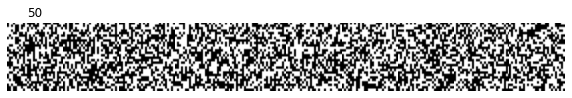

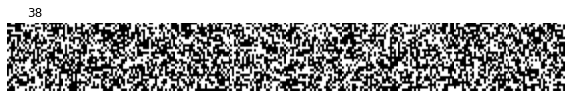

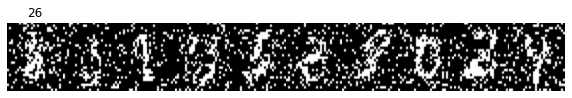

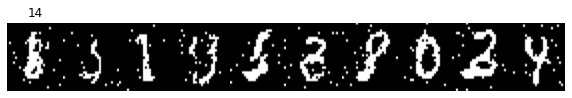

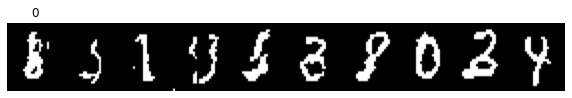

In [8]:
# Take the trained model and go backwards to sample some digits
print("Sampling some reverse trajectories")
samples, times = generate.generate_samples(
    model, diffuser, t_limit=t_limit, return_all_times=True
)
samples, times = samples.cpu().numpy(), times.cpu().numpy()
num_to_show = 4
time_inds = np.arange(0, len(times), len(times) // num_to_show)
time_inds[-1] = len(times) - 1
for t_i in time_inds:
    plot_mnist_digits(samples[t_i], grid_size=(10, 1), title=times[t_i])